### Cell 1: Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Cell 2: Data Cleaning Function

In [2]:
# Cell 2: Data Cleaning Function (Corrected)
def load_and_clean_data(file_path):
    try:
        # Load raw data
        df = pd.read_csv(file_path)
        
        # Fix header issue: District names are in row 0
        district_cols = df.iloc[0, 14:].dropna().values
        new_cols = list(df.columns[:14]) + list(district_cols)
        
        df_data = df.iloc[1:].copy()
        df_data = df_data.iloc[:, :len(new_cols)]
        df_data.columns = new_cols
        
        # Standardize column names (remove extra spaces, uppercase)
        df_data.columns = [c.strip().upper().replace('  ', ' ').replace(' ', '_') for c in df_data.columns]
        
        # Mapping standard names if necessary to ensure consistency
        # This handles 'WATER_REQUIRED_MIN' vs 'WATERREQUIRED_MAX' issues automatically via the clean above
        
        # Identify Numeric Columns based on standard names
        num_cols = ['SOIL_PH_LOW', 'SOIL_PH_HIGH', 'CROPDURATION_MIN', 'CROPDURATION_MAX', 
                    'MIN_TEMP', 'MAX_TEMP', 'WATER_REQUIRED_MIN', 'WATERREQUIRED_MAX', 
                    'RELATIVE_HUMIDITY_MIN', 'RELATIVE_HUMIDITY_MAX']
        
        # Handle minor naming variations in source CSV if needed
        # (The cleaning line above usually fixes 'TYPE_OF _WATERSOURCE' to 'TYPE_OF_WATERSOURCE')

        for col in num_cols:
            if col in df_data.columns:
                df_data[col] = pd.to_numeric(df_data[col], errors='coerce')
            
        df_data.dropna(subset=[c for c in num_cols if c in df_data.columns], inplace=True)
        
        print("Columns found:", df_data.columns.tolist())
        return df_data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

### Cell 3: Data Augmentation Function

In [3]:
# Cell 3: Data Augmentation Function (Corrected)
def augment_data(df, samples_per_crop=200):
    augmented_data = []
    # Check if columns exist before accessing
    water_source_col = 'TYPE_OF_WATERSOURCE' if 'TYPE_OF_WATERSOURCE' in df.columns else 'TYPE_OF__WATERSOURCE'
    
    for _, row in df.iterrows():
        crop = row['CROPS']
        soil = row['SOIL']
        type_crop = row['TYPE_OF_CROP']
        water_source = row.get(water_source_col, 'Unknown')
        
        for _ in range(samples_per_crop):
            # Random sampling within the min-max ranges
            ph = np.random.uniform(row['SOIL_PH_LOW'], row['SOIL_PH_HIGH'])
            dur = np.random.uniform(row['CROPDURATION_MIN'], row['CROPDURATION_MAX'])
            temp = np.random.uniform(row['MIN_TEMP'], row['MAX_TEMP'])
            
            # Handle potential naming mismatch in water columns
            w_min = row.get('WATER_REQUIRED_MIN', row.get('WATERREQUIRED_MIN', 0))
            w_max = row.get('WATERREQUIRED_MAX', row.get('WATER_REQUIRED_MAX', 0))
            water = np.random.uniform(w_min, w_max)
            
            humid = np.random.uniform(row['RELATIVE_HUMIDITY_MIN'], row['RELATIVE_HUMIDITY_MAX'])
            
            augmented_data.append([crop, type_crop, soil, water_source, ph, dur, temp, water, humid])
            
    return pd.DataFrame(augmented_data, columns=['CROPS', 'TYPE_OF_CROP', 'SOIL', 'WATER_SOURCE', 
                                                 'PH', 'DURATION', 'TEMP', 'WATER', 'HUMIDITY'])

### Cell 4: Model Architectures

In [4]:
# --- Model Definitions ---

class CNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * (input_dim // 2), output_dim) 
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 64, batch_first=True)
        self.fc = nn.Linear(64, output_dim)
    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, 64, batch_first=True)
        self.fc = nn.Linear(64, output_dim)
    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, 64)
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.fc = nn.Linear(64, output_dim)
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

class ResidualMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x1 = self.relu(self.fc1(x))
        x2 = self.relu(self.fc2(x1))
        x = x1 + x2
        x = self.fc3(x)
        return x

class Hybrid_CNNLSTM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Hybrid_CNNLSTM, self).__init__()
        self.conv = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(64, 64, batch_first=True)
        self.fc = nn.Linear(64, output_dim)
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

### Cell 5: Data Pipeline Execution

In [5]:
# Cell 5: Data Pipeline Execution (Final Corrected Version)

# Define file path
file_path = 'Tamil Nadu - AgriData_Dist.csv' 

print(f"Loading data from {file_path}...")
df = load_and_clean_data(file_path)

if df is not None:
    print(f"Data loaded. Original rows: {len(df)}")
    
    # --- STRATEGY CHANGE: Augment First, Then Split ---
    # Since your dataset has 1 row per crop (unique rules), we cannot split the original rows.
    # We will augment the entire dataset first to generate variations, then split.
    
    print("Augmenting entire dataset (200 samples per row)...")
    aug_df = augment_data(df, samples_per_crop=200)
    print(f"Augmented Dataset Size: {len(aug_df)}")
    
    # --- Preprocessing & Encoding ---
    le_dict = {}
    
    # Helper to encode and store label encoders
    def encode_column(data, col_name, target_name):
        le = LabelEncoder()
        data[target_name] = le.fit_transform(data[col_name].astype(str))
        le_dict[col_name] = le # Store original col name as key
        return data

    # 1. Encode Categorical Features
    # Note: We use specific output names to match the features list later
    aug_df = encode_column(aug_df, 'CROPS', 'CROPS_ENC')
    aug_df = encode_column(aug_df, 'SOIL', 'SOIL_ENC')
    aug_df = encode_column(aug_df, 'TYPE_OF_CROP', 'TYPE_ENC')       # Fixed Name Mismatch
    aug_df = encode_column(aug_df, 'WATER_SOURCE', 'SOURCE_ENC')     # Fixed Name Mismatch
    
    # Define Features List (Must match the encoded names above)
    features = ['SOIL_ENC', 'TYPE_ENC', 'SOURCE_ENC', 'PH', 'DURATION', 'TEMP', 'WATER', 'HUMIDITY']
    
    X = aug_df[features].values
    y = aug_df['CROPS_ENC'].values
    
    # --- Train/Test Split ---
    # Now we have 21,000 rows, so we can split safely
    print("Splitting into Train and Test sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"Train Size: {len(X_train)}")
    print(f"Test Size: {len(X_test)}")
    
    # --- Scaling ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
        
    # --- Convert to Tensors ---
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)
    
    # Define Dimensions for Model
    input_dim = X_train.shape[1]
    output_dim = len(le_dict['CROPS'].classes_)
    
    print("Data processing complete. Tensors ready.")
else:
    print("Failed to load data. Please check file path.")

Loading data from Tamil Nadu - AgriData_Dist.csv...
Columns found: ['CROPS', 'TYPE_OF_CROP', 'SOIL', 'SOIL_PH_LOW', 'SOIL_PH_HIGH', 'CROPDURATION_MIN', 'CROPDURATION_MAX', 'MIN_TEMP', 'MAX_TEMP', 'TYPE_OF__WATERSOURCE', 'WATER_REQUIRED_MIN', 'WATERREQUIRED_MAX', 'RELATIVE_HUMIDITY_MIN', 'RELATIVE_HUMIDITY_MAX', 'ARIYALUR', 'CAUVERY', 'CHENGLEPUT', 'COIMBATORE', 'CUDDALORE', 'DHARMAPURI', 'DINDIGUL', 'ERODE', 'HILLY_REGIONS_OF_SHEVROY', 'JAWAD_HILLS', 'KANCHEEPURAM', 'KANYAKUMARI', 'KARUR', 'KOLLI_HILLS', 'KRISHNAGIRI', 'MADURAI', 'NAGAPATTINAM', 'NAMAKAL', 'PERAMBALUR', 'PUDUKKOTTAI', 'RAMANATHANPURAM', 'SALEM', 'SIVAGANGAI', 'TANJORE', 'THALAVADI_HILLS', 'THE_NILGRIS', 'THENI', 'THIRUCHIRAPALLI', 'THIRUNELVELI', 'THIRUPPUR', 'THIRUVALLUR', 'THIRUVANNAMALAI', 'THOOTHUKUDI', 'TIRUVARUR', 'VELLORE', 'VILLUPURAM', 'VIRUDHUNAGAR']
Data loaded. Original rows: 105
Augmenting entire dataset (200 samples per row)...
Augmented Dataset Size: 21000
Splitting into Train and Test sets...
Train Size

### Cell 6: Data Visualization (EDA)

Generating Exploratory Data Analysis (EDA) charts...


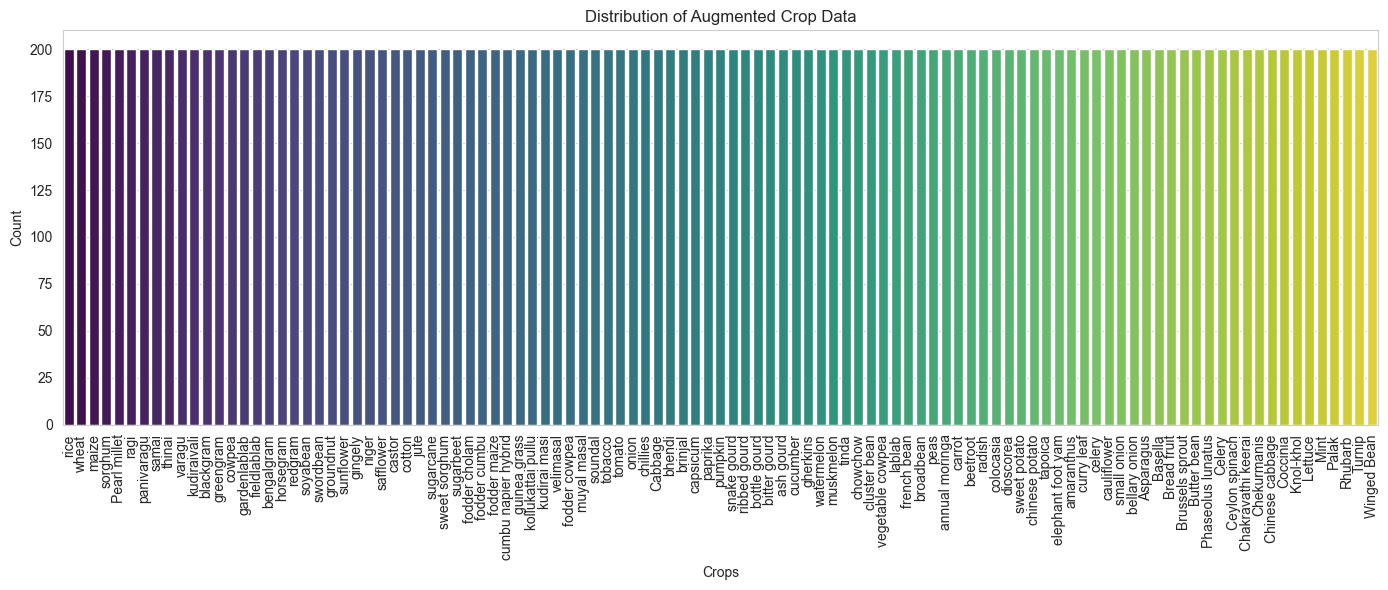

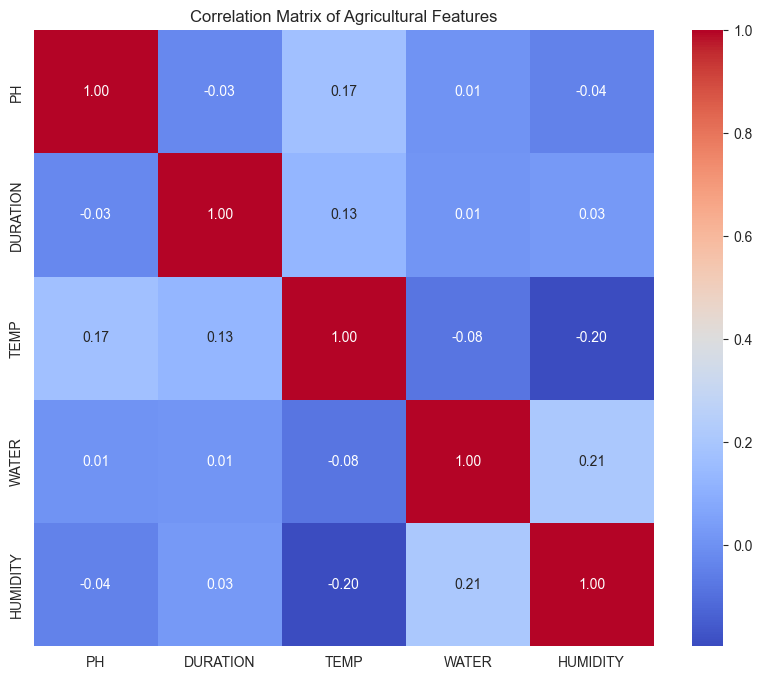

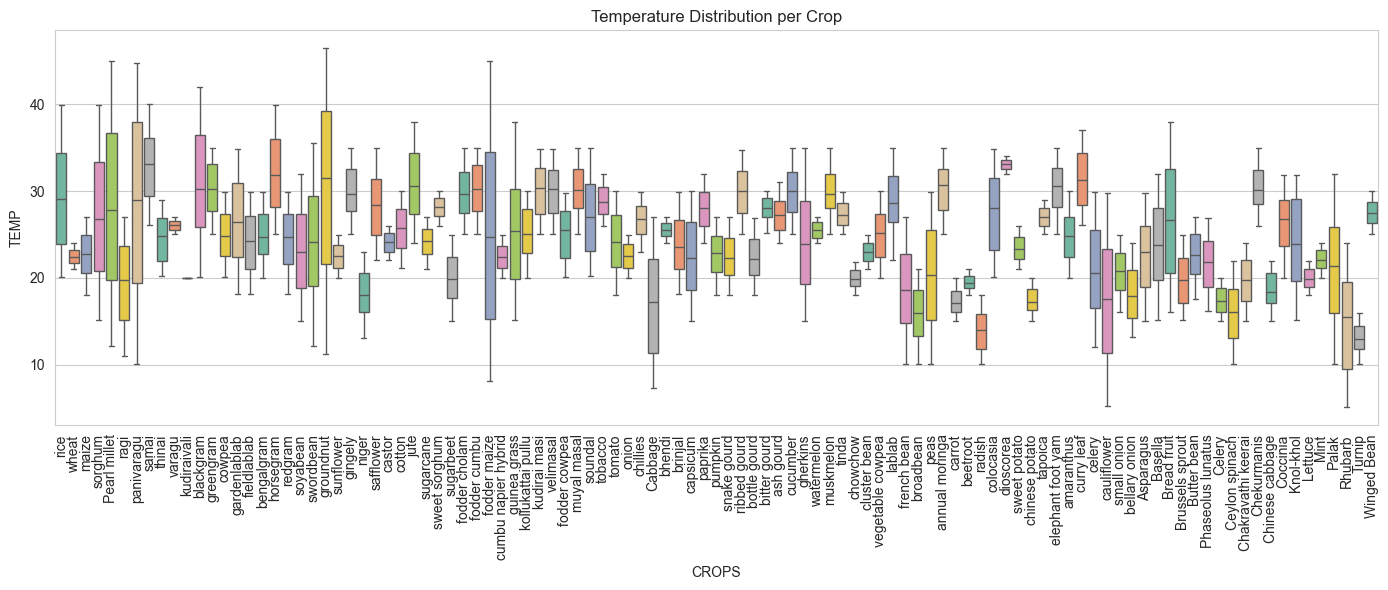

In [6]:
if df is not None:
    print("Generating Exploratory Data Analysis (EDA) charts...")

    # 1. Target Variable Distribution (Classes)
    plt.figure(figsize=(14, 6))
    # FIX: Added hue='CROPS' and legend=False
    sns.countplot(
        data=aug_df, 
        x='CROPS', 
        hue='CROPS', 
        legend=False, 
        palette='viridis', 
        order=aug_df['CROPS'].value_counts().index
    )
    plt.title("Distribution of Augmented Crop Data")
    plt.xticks(rotation=90)
    plt.xlabel("Crops")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # 2. Correlation Matrix of Numerical Features
    numeric_cols = ['PH', 'DURATION', 'TEMP', 'WATER', 'HUMIDITY']
    plt.figure(figsize=(10, 8))
    sns.heatmap(aug_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix of Agricultural Features")
    plt.show()

    # 3. Boxplot of Temperature vs Crops
    plt.figure(figsize=(14, 6))
    sns.boxplot(
        data=aug_df, 
        x='CROPS', 
        y='TEMP', 
        hue='CROPS', 
        legend=False, 
        palette='Set2'
    )
    plt.xticks(rotation=90)
    plt.title("Temperature Distribution per Crop")
    plt.tight_layout()
    plt.show()

### Cell 7: High-Dimensional Cluster Analysis (t-SNE)

Generating t-SNE Cluster Visualization (This may take a moment)...


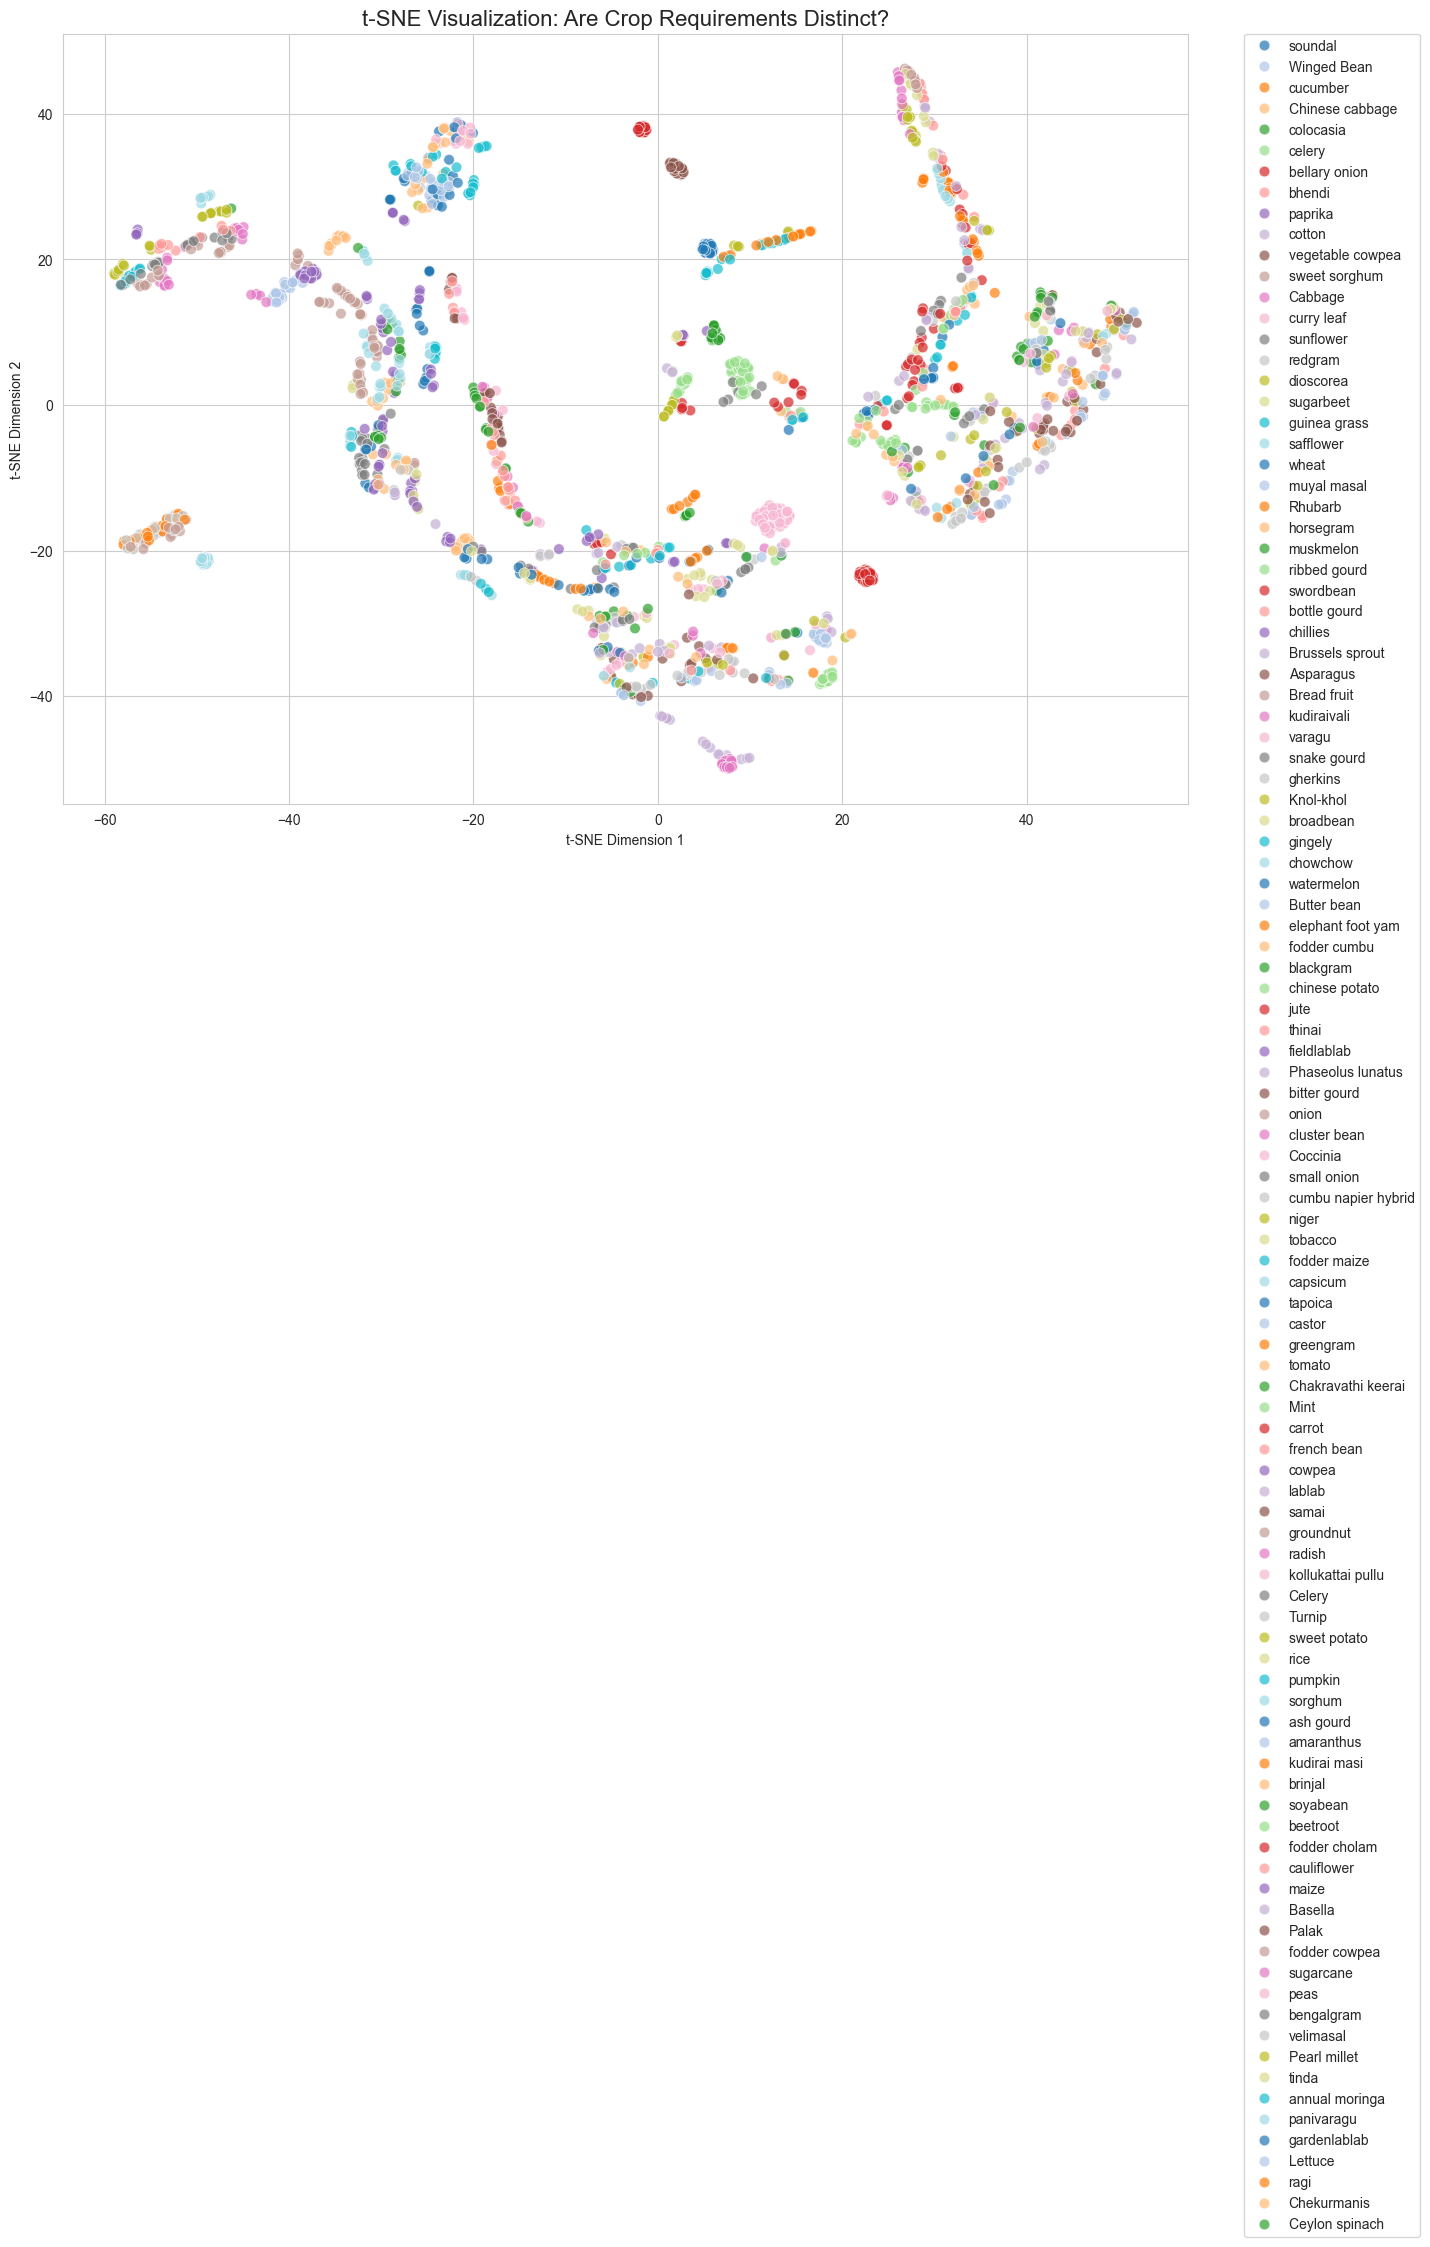

In [7]:
from sklearn.manifold import TSNE

if df is not None:
    print("Generating t-SNE Cluster Visualization (This may take a moment)...")
    
    # 1. Downsample for speed (using 2000 random samples)
    # t-SNE is very slow on the full augmented dataset
    subset_idx = np.random.choice(range(len(X)), size=2000, replace=False)
    X_subset = X[subset_idx]
    y_subset = y[subset_idx]
    
    # 2. Run t-SNE to project 8 dimensions down to 2
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_embedded = tsne.fit_transform(X_subset)
    
    # 3. Plot
    # Increased width to 18 to accommodate the side legend
    plt.figure(figsize=(18, 10))
    
    # Map numeric labels back to crop names for the legend
    crop_labels = le_dict['CROPS'].inverse_transform(y_subset)
    
    sns.scatterplot(
        x=X_embedded[:, 0], 
        y=X_embedded[:, 1], 
        hue=crop_labels, 
        palette='tab20', # High contrast palette to distinguish many crops
        legend='full',
        s=60,
        alpha=0.7
    )
    plt.title("t-SNE Visualization: Are Crop Requirements Distinct?", fontsize=16)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    
    # FIX: Manually adjust margins instead of using tight_layout
    # This reserves the right 25% of the image for the legend
    plt.subplots_adjust(right=0.75)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.show()

### Cell 8: Feature Density Distribution

Generating Feature Density Plots...


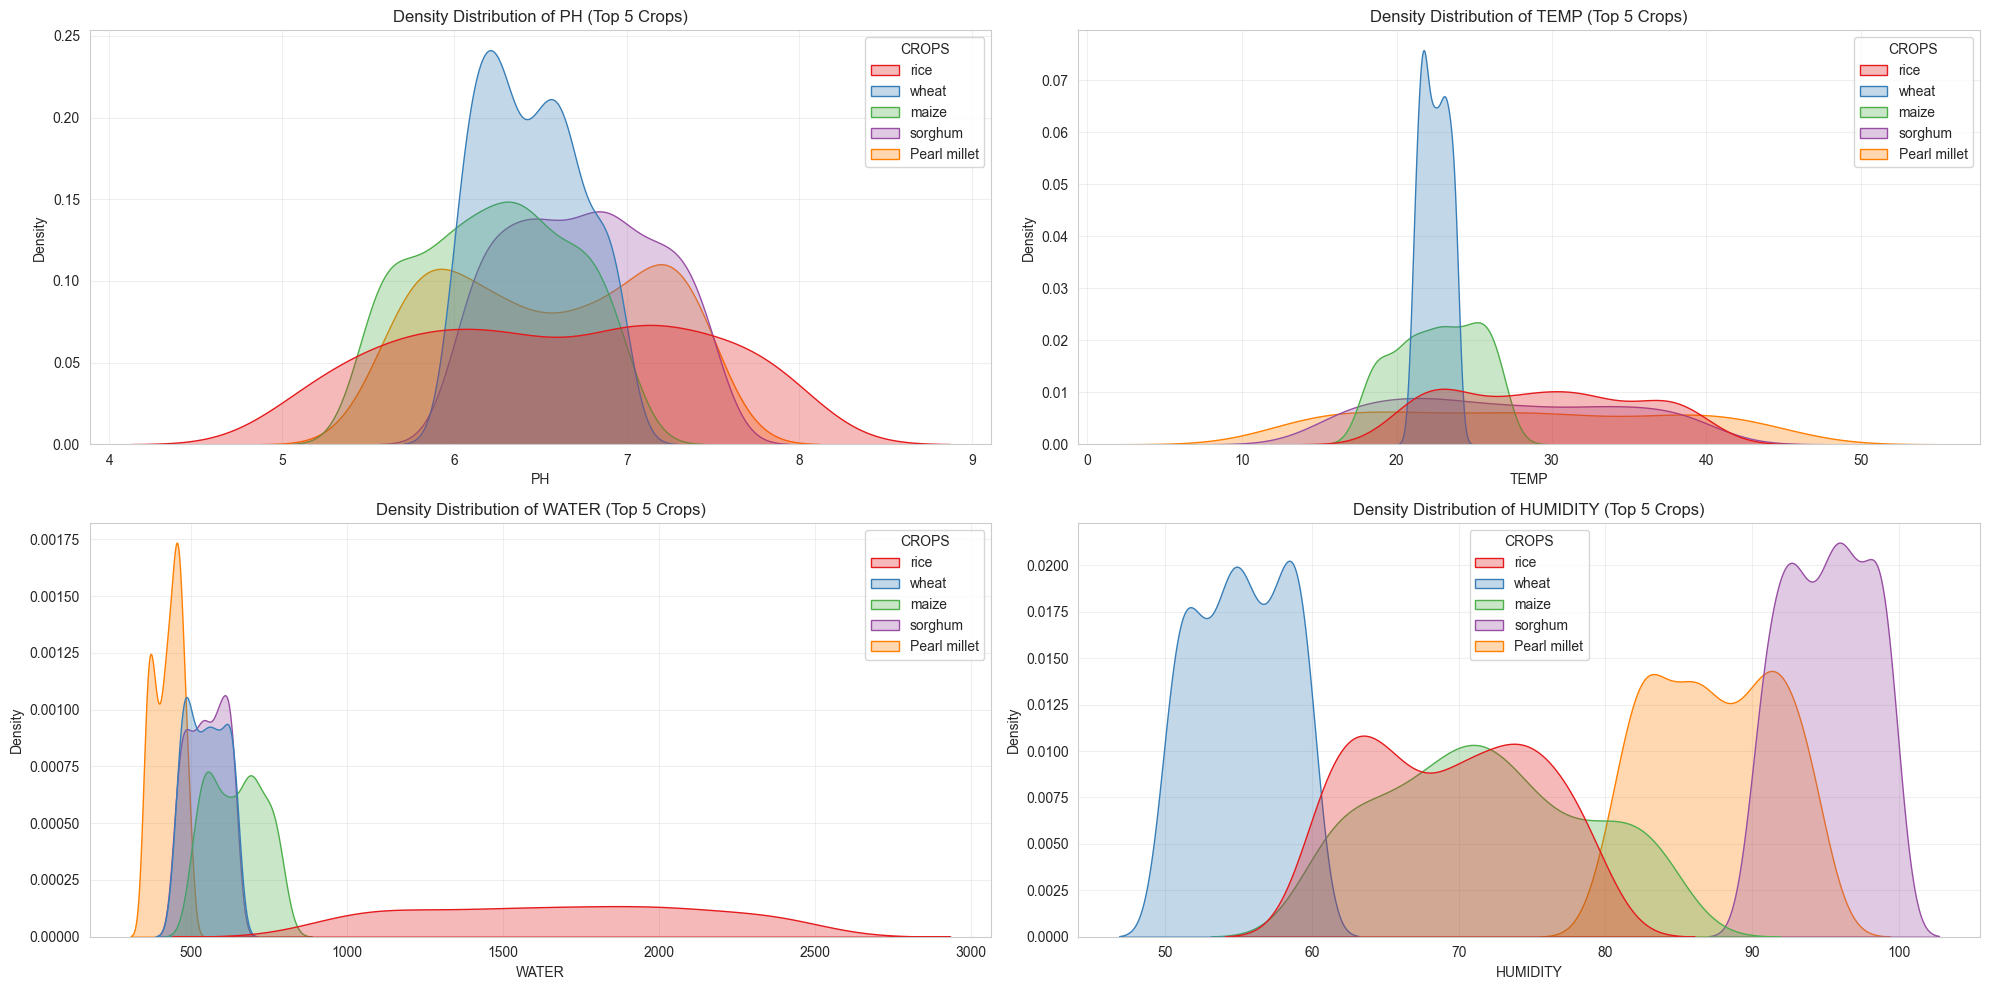

In [8]:
if df is not None:
    print("Generating Feature Density Plots...")
    features_to_plot = ['PH', 'TEMP', 'WATER', 'HUMIDITY']
    
    plt.figure(figsize=(20, 10))
    for i, col in enumerate(features_to_plot):
        plt.subplot(2, 2, i+1)
        
        # Plotting only top 5 most frequent crops to keep the chart readable
        top_crops = aug_df['CROPS'].value_counts().index[:5]
        subset_df = aug_df[aug_df['CROPS'].isin(top_crops)]
        
        sns.kdeplot(data=subset_df, x=col, hue='CROPS', fill=True, alpha=0.3, palette='Set1')
        plt.title(f'Density Distribution of {col} (Top 5 Crops)')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Cell 9: Training Loop

In [9]:
# --- Advanced Training Setup with Early Stopping ---
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5):
    """
    Trains a model with Early Stopping to prevent overfitting.
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total * 100
        val_loss_history.append(epoch_val_loss)
        
        # Check for Early Stopping
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0 # Reset counter if performance improved
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"   -> Early stopping triggered at epoch {epoch+1}")
            break
            
    # Load best model weights before returning
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, best_acc

if df is not None:
    # Prepare DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor) # Using Test as Validation here
    
    BATCH_SIZE = 64
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Re-initialize models
    models = {
        "CNN": CNNModel(input_dim, output_dim).to(device),
        "LSTM": LSTMModel(input_dim, output_dim).to(device),
        "GRU": GRUModel(input_dim, output_dim).to(device),
        "Transformer": TransformerModel(input_dim, output_dim).to(device),
        "ResidualMLP": ResidualMLP(input_dim, output_dim).to(device),
        "Hybrid_CNNLSTM": Hybrid_CNNLSTM(input_dim, output_dim).to(device)
    }
    
    metrics = {}
    loss_histories = {}
    
    print("\n--- Starting Advanced Training Loop ---\n")
    
    for name, model in models.items():
        print(f"Training {name}...")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train
        trained_model, t_loss, v_loss, best_acc = train_model(
            model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5
        )
        
        metrics[name] = best_acc
        loss_histories[name] = {'train': t_loss, 'val': v_loss}
        print(f" > {name} Best Validation Accuracy: {best_acc:.2f}%")


--- Starting Advanced Training Loop ---

Training CNN...
   -> Early stopping triggered at epoch 21
 > CNN Best Validation Accuracy: 97.79%
Training LSTM...
 > LSTM Best Validation Accuracy: 98.36%
Training GRU...
 > GRU Best Validation Accuracy: 98.52%
Training Transformer...
 > Transformer Best Validation Accuracy: 98.71%
Training ResidualMLP...
   -> Early stopping triggered at epoch 16
 > ResidualMLP Best Validation Accuracy: 98.26%
Training Hybrid_CNNLSTM...
 > Hybrid_CNNLSTM Best Validation Accuracy: 98.21%


### Cell 10: Model Performance Visualization


Best Performing DL Model: Transformer


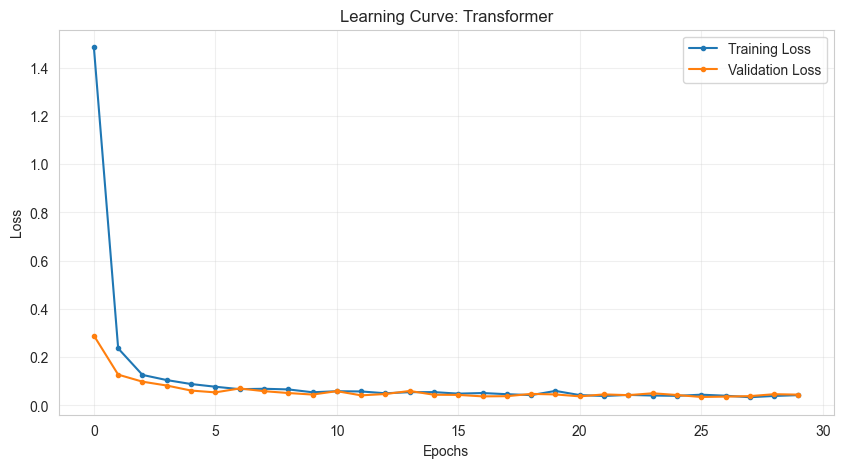


Training Random Forest (ML Baseline) for Comparison...
 > RandomForest Accuracy: 99.43%


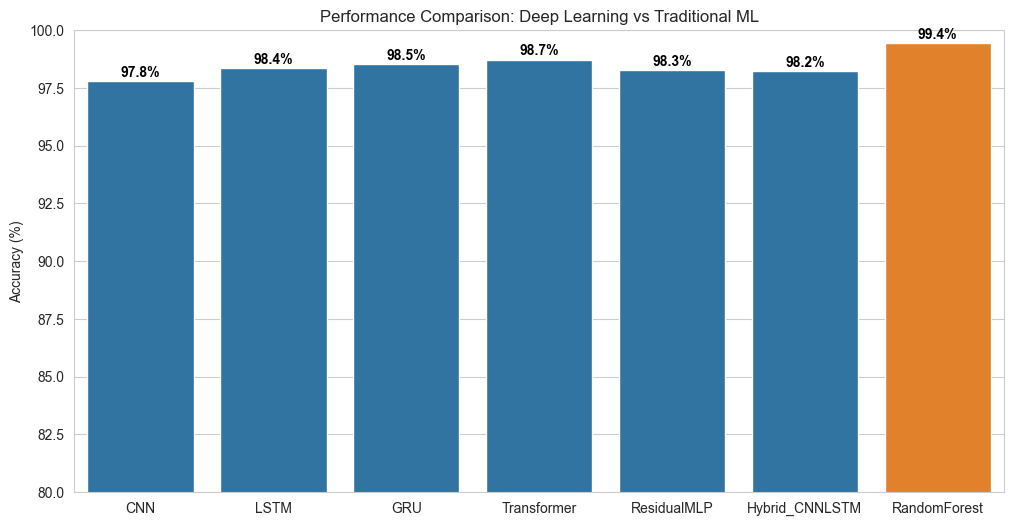


--- Classification Report (Transformer) ---
                     precision    recall  f1-score   support

          Asparagus       1.00      1.00      1.00        40
            Basella       1.00      1.00      1.00        40
        Bread fruit       1.00      1.00      1.00        40
    Brussels sprout       1.00      1.00      1.00        40
        Butter bean       0.76      0.65      0.70        40
            Cabbage       1.00      1.00      1.00        40
             Celery       1.00      1.00      1.00        40
     Ceylon spinach       0.93      1.00      0.96        40
 Chakravathi keerai       0.83      1.00      0.91        40
        Chekurmanis       1.00      0.95      0.97        40
    Chinese cabbage       1.00      1.00      1.00        40
           Coccinia       0.83      1.00      0.91        40
          Knol-khol       1.00      0.93      0.96        40
            Lettuce       1.00      0.95      0.97        40
               Mint       1.00      1.0

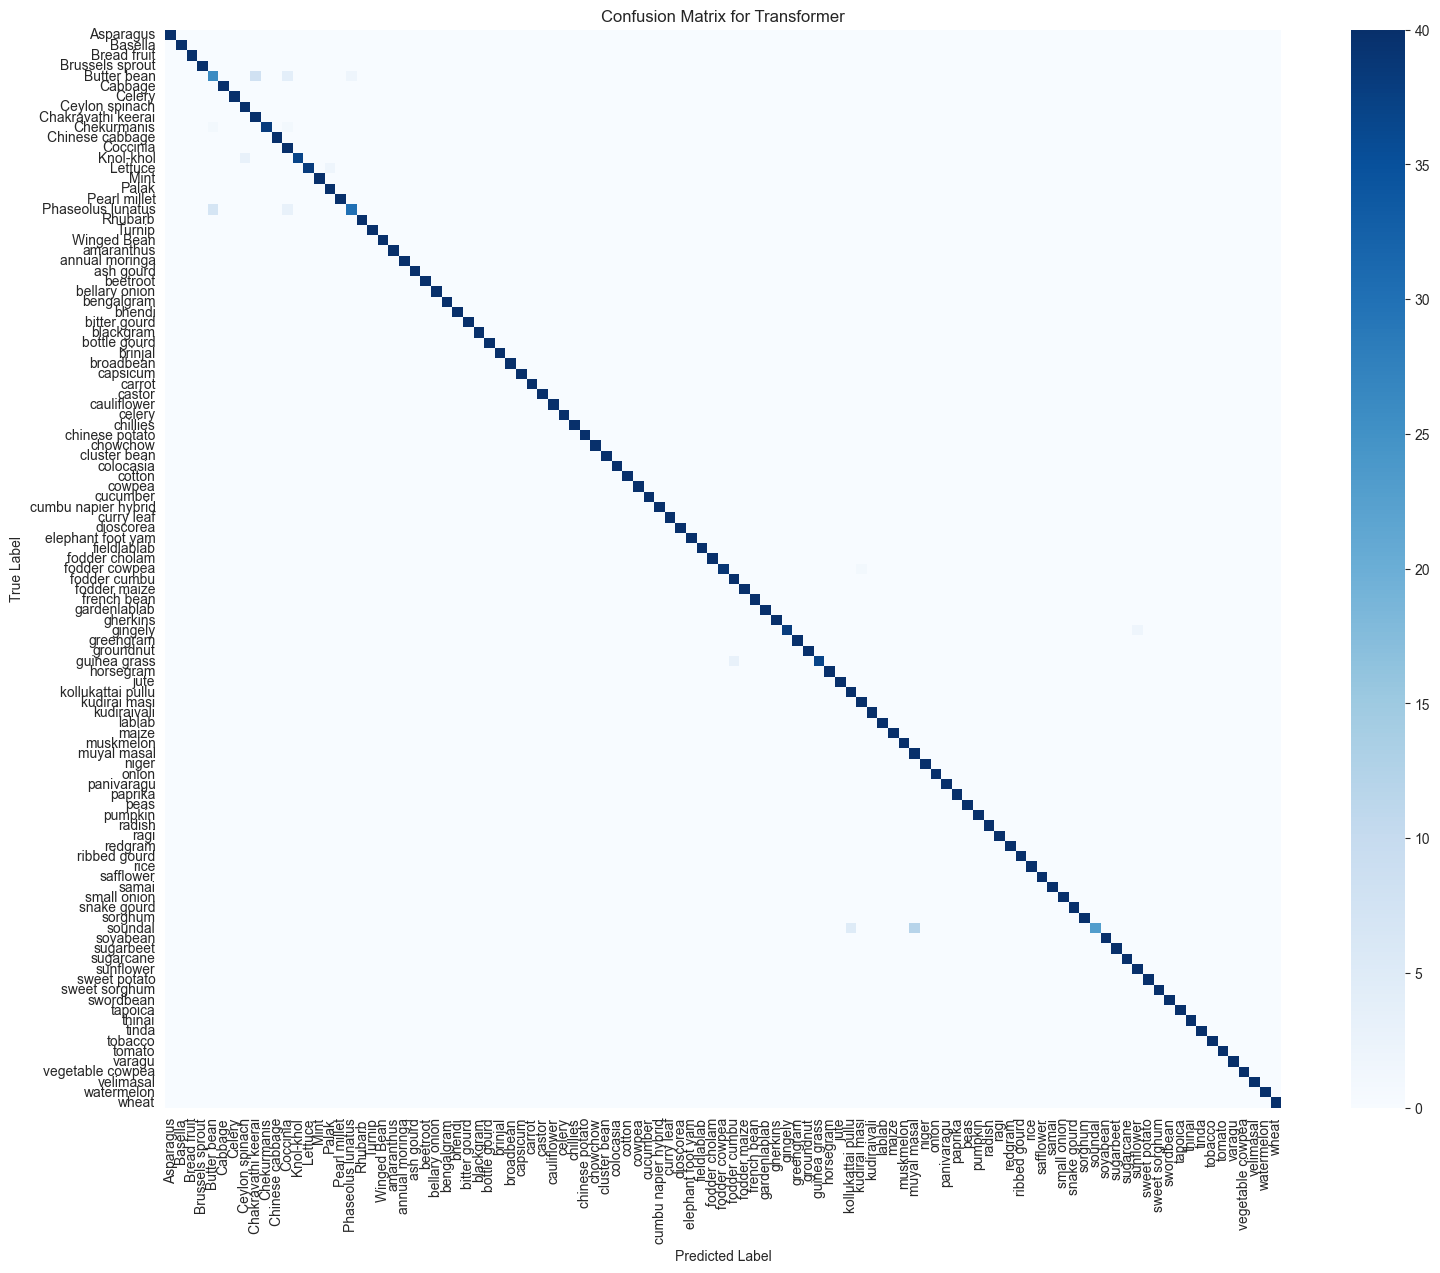

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

if df is not None:
    # --- 1. Learning Curves ---
    # Determine best DL model
    best_model_name = max(metrics, key=metrics.get)
    print(f"\nBest Performing DL Model: {best_model_name}")
    
    hist = loss_histories[best_model_name]
    plt.figure(figsize=(10, 5))
    plt.plot(hist['train'], label='Training Loss', marker='.')
    plt.plot(hist['val'], label='Validation Loss', marker='.')
    plt.title(f"Learning Curve: {best_model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- 2. ML Baseline Comparison ---
    print("\nTraining Random Forest (ML Baseline) for Comparison...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_acc = rf_model.score(X_test, y_test) * 100
    metrics['RandomForest'] = rf_acc
    print(f" > RandomForest Accuracy: {rf_acc:.2f}%")

    # Bar Chart Comparison
    plt.figure(figsize=(12, 6))
    names = list(metrics.keys())
    values = list(metrics.values())
    colors = ['#1f77b4' if 'Random' not in n else '#ff7f0e' for n in names]
    
    # FIX: Assign 'x' variable to 'hue' and set 'legend=False' to fix Warning
    barplot = sns.barplot(x=names, y=values, hue=names, legend=False, palette=colors)
    
    plt.ylim(80, 100) # Start y-axis at 80 to show differences clearly
    for i, v in enumerate(values):
        barplot.text(i, v + 0.2, f"{v:.1f}%", color='black', ha="center", fontweight='bold')
    plt.title("Performance Comparison: Deep Learning vs Traditional ML")
    plt.ylabel("Accuracy (%)")
    plt.show()

    # --- 3. Detailed Metrics (Confusion Matrix) ---
    # Get predictions from best DL model
    best_net = models[best_model_name]
    best_net.eval()
    with torch.no_grad():
        logits = best_net(torch.FloatTensor(X_test).to(device))
        _, preds = torch.max(logits, 1)
        preds_np = preds.cpu().numpy()
        
    target_names = [str(c) for c in le_dict['CROPS'].classes_]
    
    print(f"\n--- Classification Report ({best_model_name}) ---")
    print(classification_report(y_test, preds_np, target_names=target_names))
    
    plt.figure(figsize=(18, 14))
    cm = confusion_matrix(y_test, preds_np)
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f"Confusion Matrix for {best_model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Cell 11: Save Encoders and Models

In [11]:
if df is not None:
    # Save Encoders for app.py
    with open('encoders.pkl', 'wb') as f:
        pickle.dump({'encoders': le_dict, 'scaler': scaler}, f)
    print("Saved encoders.pkl")

    # Save metrics to JSON
    with open('model_metrics.json', 'w') as f:
        json.dump(metrics, f)
    print("Saved model_metrics.json")
    
    # Save PyTorch Models
    for name, model in models.items():
        torch.save(model.state_dict(), f"{name}_model.pth")
        print(f"Saved {name}_model.pth")

Saved encoders.pkl
Saved model_metrics.json
Saved CNN_model.pth
Saved LSTM_model.pth
Saved GRU_model.pth
Saved Transformer_model.pth
Saved ResidualMLP_model.pth
Saved Hybrid_CNNLSTM_model.pth


### Cell 12: Manual Prediction Test

In [12]:
# --- Manual Prediction Test ---
# This simulates how the system will work in the real world (or app.py)

if df is not None:
    print("\n--- 🟢 MANUAL PREDICTION TEST ---")
    
    # 1. Select a random real sample from the dataset to test
    # Change test_index to test different rows (e.g., 0, 100, 500)
    test_index = 0 
    sample_row = aug_df.iloc[test_index]
    actual_crop = sample_row['CROPS']
    
    print(f"Testing with known data for crop: {actual_crop}")
    
    # 2. Prepare the input dictionary (Simulating User Input)
    user_input = {
        'SOIL': sample_row['SOIL'],
        'TYPE_OF_CROP': sample_row['TYPE_OF_CROP'],
        'WATER_SOURCE': sample_row['WATER_SOURCE'],
        'PH': sample_row['PH'],
        'DURATION': sample_row['DURATION'],
        'TEMP': sample_row['TEMP'],
        'WATER': sample_row['WATER'],
        'HUMIDITY': sample_row['HUMIDITY']
    }
    
    print(f"Input Data: {user_input}")
    
    # 3. Preprocessing (Must match training pipeline exactly)
    try:
        # Encode Categorical Features using the saved encoders
        soil_enc = le_dict['SOIL'].transform([user_input['SOIL']])[0]
        type_enc = le_dict['TYPE_OF_CROP'].transform([user_input['TYPE_OF_CROP']])[0]
        source_enc = le_dict['WATER_SOURCE'].transform([user_input['WATER_SOURCE']])[0]
        
        # Create Array (Corrected syntax)
        raw_features = np.array([[
            soil_enc, 
            type_enc, 
            source_enc, 
            user_input['PH'], 
            user_input['DURATION'], 
            user_input['TEMP'], 
            user_input['WATER'], 
            user_input['HUMIDITY']
        ]])
        
        # Scale Features using the saved scaler
        scaled_features = scaler.transform(raw_features)
        
        # Convert to Tensor for PyTorch
        tensor_input = torch.FloatTensor(scaled_features).to(device)
        
        # 4. Predict with ALL models to check consistency
        print("\nModel Predictions:")
        print("-" * 40)
        
        for name, model in models.items():
            model.eval()
            with torch.no_grad():
                logits = model(tensor_input)
                probs = torch.nn.functional.softmax(logits, dim=1)
                confidence, pred_idx = torch.max(probs, 1)
                
                pred_crop_name = le_dict['CROPS'].inverse_transform([pred_idx.item()])[0]
                
                # Check correctness
                if pred_crop_name == actual_crop:
                    result_icon = "✅ Correct" 
                else:
                    result_icon = "❌ Incorrect"
                
                print(f"{name.ljust(15)}: {pred_crop_name.ljust(15)} | Conf: {confidence.item()*100:.2f}% | {result_icon}")
                
    except Exception as e:
        print(f"Error during manual prediction: {e}")


--- 🟢 MANUAL PREDICTION TEST ---
Testing with known data for crop: rice
Input Data: {'SOIL': 'Alluvia or loamy and clayey soil', 'TYPE_OF_CROP': 'cereals', 'WATER_SOURCE': 'both', 'PH': np.float64(5.761215632447232), 'DURATION': np.float64(150.0), 'TEMP': np.float64(31.792847495286175), 'WATER': np.float64(1929.0559698955249), 'HUMIDITY': np.float64(76.7165049536782)}

Model Predictions:
----------------------------------------
CNN            : rice            | Conf: 100.00% | ✅ Correct
LSTM           : rice            | Conf: 99.91% | ✅ Correct
GRU            : rice            | Conf: 99.97% | ✅ Correct
Transformer    : rice            | Conf: 100.00% | ✅ Correct
ResidualMLP    : rice            | Conf: 99.99% | ✅ Correct
Hybrid_CNNLSTM : rice            | Conf: 99.93% | ✅ Correct
